<a href="https://colab.research.google.com/github/IMakeTheSites/python_practice/blob/main/imageClassifier_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning with TensorFlow Hub**

**Image Classification**

In [3]:
# Enable TensorFlow 2.0
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [9]:
# Import Tensorflow
import tensorflow as tf
tf.__version__

'2.15.0'

In [5]:
# Install tfds-nightly so we can download oxford_flowers102 version 2.1.0
!pip install tfds-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 12.9 MB/s eta 0:00:00


In [12]:
# Import TensorFlow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Import Keras
from tensorflow import keras

# Import TensorFlow Hub
import tensorflow_hub as hub

# Import Numpy
import numpy as np
import matplotlib.pyplot as plt



## **Data pipeline**

### Load the dataset


### OxFord Flowers 102 is one of the TensorFlow 2.0 datasets with 102 category of common flowers in the UK.

In [18]:
# Load train and validation datasets
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='oxford_flowers102:2.1.1',
    split=['test', 'validation', 'train'],
    with_info=True,
    as_supervised=True
)

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [19]:
num_classes = metadata.features['label'].num_classes
num_train = len(list(raw_train))
num_validation = len(list(raw_validation))
num_test = len(list(raw_test))

print("Number of fclasses:", num_classes)
print("Number of training samples:", num_train)
print("Number of validation samples:", num_validation)
print("Number of test samples:", num_test)

Number of fclasses: 102
Number of training samples: 6149
Number of validation samples: 1020
Number of test samples: 1020


In [5]:
# Inspect datasets before data preprocessing
print(raw_train)
print(raw_validation)
print(raw_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [6]:
classlabel = metadata.features['label']
classlabel.get_serialized_info

<bound method Tensor.get_serialized_info of ClassLabel(shape=(), dtype=int64, num_classes=102)>

In [33]:
# Get labels / class names
class_names = np.array(metadata.features['label'].names)
class_names

array(['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells',
       'sweet pea', 'english marigold', 'tiger lily', 'moon orchid',
       'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon',
       "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
       'globe-flower', 'purple coneflower', 'peruvian lily',
       'balloon flower', 'giant white arum lily', 'fire lily',
       'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
       'corn poppy', 'prince of wales feathers', 'stemless gentian',
       'artichoke', 'sweet william', 'carnation', 'garden phlox',
       'love in the mist', 'mexican aster', 'alpine sea holly',
       'ruby-lipped cattleya', 'cape flower', 'great masterwort',
       'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
       'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower',
       'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
       'petunia', 'wild pansy', 'primula', 'sunflower

Visualize data (Flower Images)

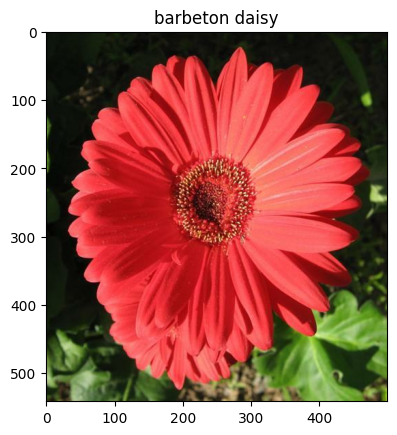

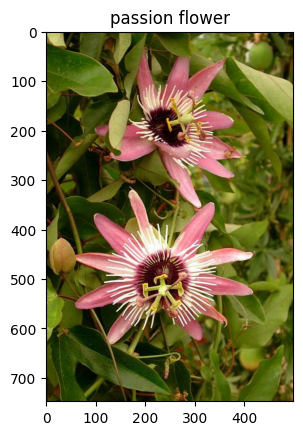

In [8]:
label_names = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(label_names(label))

Image preprocessing - Resize, normalize, augment, shuffle, batch

In [14]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image/255.0
  return image, label

In [24]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [16]:
def augment_data(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  image = tf.stack(image, axis=0)
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  return image, label

In [17]:
train = train.map(augment_data)


Shuffle and batch dataset

In [25]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
validation_batches = validation.batch(BATCH_SIZE).repeat()
test_batches = test.batch(BATCH_SIZE)

In [19]:
# Inspect datasets after data preprocessing
print(train_batches)
print(validation_batches)
print(test_batches)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [20]:
# Inspect a batch of data
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])

# Training - Create the model

In [15]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape = IMG_SHAPE, trainable=False)

In [20]:
model = tf.keras.Sequential([feature_extractor_layer,
                             tf.keras.layers.Dense(num_classes, activation='softmax')
                      ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Compile the model

In [21]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train the model

In [27]:
# Set training parameters
NUM_EPOCHS = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = round(num_validation)//BATCH_SIZE

In [28]:
history = model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_batches,
    validation_steps=validation_steps
)

Epoch 1/10
192/192 [==============================] - 291s 1s/step - loss: 1.9863 - accuracy: 0.5955 - val_loss: 1.0291 - val_accuracy: 0.7712
Epoch 2/10
192/192 [==============================] - 282s 1s/step - loss: 0.5430 - accuracy: 0.9037 - val_loss: 0.6582 - val_accuracy: 0.8558
Epoch 3/10
192/192 [==============================] - 265s 1s/step - loss: 0.3139 - accuracy: 0.9500 - val_loss: 0.5358 - val_accuracy: 0.8690
Epoch 4/10
192/192 [==============================] - 299s 2s/step - loss: 0.2109 - accuracy: 0.9704 - val_loss: 0.4731 - val_accuracy: 0.8810
Epoch 5/10
192/192 [==============================] - 259s 1s/step - loss: 0.1481 - accuracy: 0.9828 - val_loss: 0.4518 - val_accuracy: 0.8901
Epoch 6/10
192/192 [==============================] - 269s 1s/step - loss: 0.1147 - accuracy: 0.9894 - val_loss: 0.4298 - val_accuracy: 0.8942
Epoch 7/10
192/192 [==============================] - 266s 1s/step - loss: 0.0850 - accuracy: 0.9949 - val_loss: 0.3995 - val_accuracy: 0.9062

In [29]:
# Display training curves
def display_training_curves(history, title):
  acc =  history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(NUM_EPOCHS)

  plt.plot(epochs_range, acc, label='Train accuracy')
  plt.plot(epochs_range, val_acc, label='Val accuracy')
  plt.title(title)
  plt.legend(loc='upper left')
  plt.figure()

  plt.show()

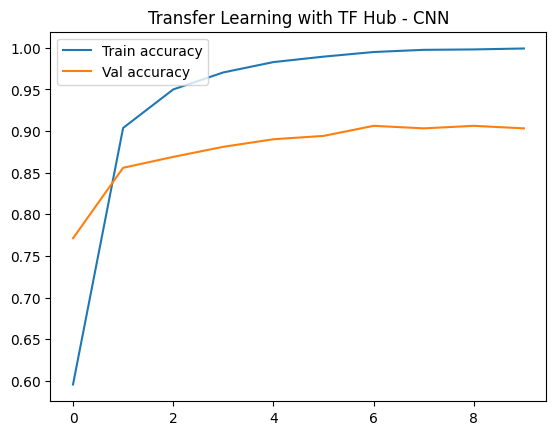

<Figure size 640x480 with 0 Axes>

In [30]:
# Display training curve
display_training_curves(history, "Transfer Learning with TF Hub - CNN")

### Test Accuracy

In [31]:
# Evaluate the model on the test dataset
score = model.evaluate(test_batches, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8803921341896057


In [34]:
image_batch, label_batch = next(iter(test_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_class_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_class_ids]

1/1 [==============================] - 1s 1s/step


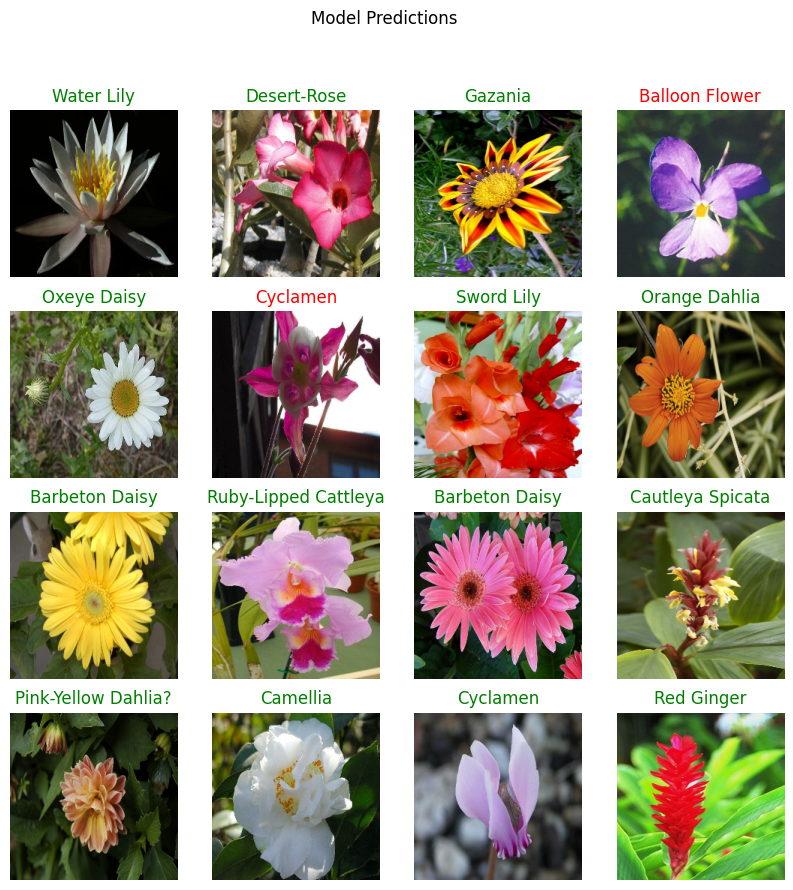

In [35]:
plt.figure(figsize=(10,10))

# Display 16 test images with predictions
for i in range(16):
  plt.subplot(4, 4, i+1)
  # Display each image
  plt.imshow(image_batch[i])
  # Set title color: green if prediction correct and red if prediction incorrect
  title_color = "green" if predicted_class_ids[i] == label_batch[i] else "red"
  plt.title(predicted_class_names[i].title(), color=title_color)
  plt.axis('off')

_ = plt.suptitle("Model Predictions")